In [1]:
import torch


def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z


print('스칼라 입력 : ', compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3)))
print('랭크 1 입력 : ', compute_z(torch.tensor([1]), torch.tensor([2]), torch.tensor([3])))
print('랭크 2 입력 : ', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))

스칼라 입력 :  tensor(1)
랭크 1 입력 :  tensor([1])
랭크 2 입력 :  tensor([[1]])


In [2]:
a = torch.tensor(3.14, requires_grad=True)
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(a)
print(b)

tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


In [3]:
w = torch.tensor([1.0, 2.0, 3.0])
print(w.requires_grad)
w.requires_grad_()
print(w.requires_grad)

False
True


In [4]:
import torch.nn as nn

torch.manual_seed(1)
w = torch.empty(2, 3)
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [5]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)

In [6]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w, x), b)

loss = (y - z).pow(2).sum()
loss.backward()

print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


In [7]:
print(2 * x * ((w * x + b) - y))

tensor([-0.5600], grad_fn=<MulBackward0>)


In [8]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [9]:
nn.init.xavier_uniform_(model[0].weight)

l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

In [10]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

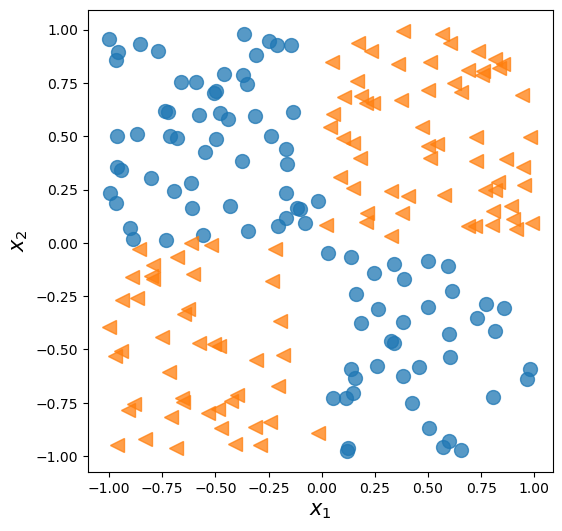

In [11]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y == 0, 0], x[y == 0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y == 1, 0], x[y == 1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [12]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [13]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [14]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [15]:
torch.manual_seed(1)
num_epochs = 200


def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train / batch_size
        accuracy_hist_train[epoch] /= n_train / batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred >= 0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

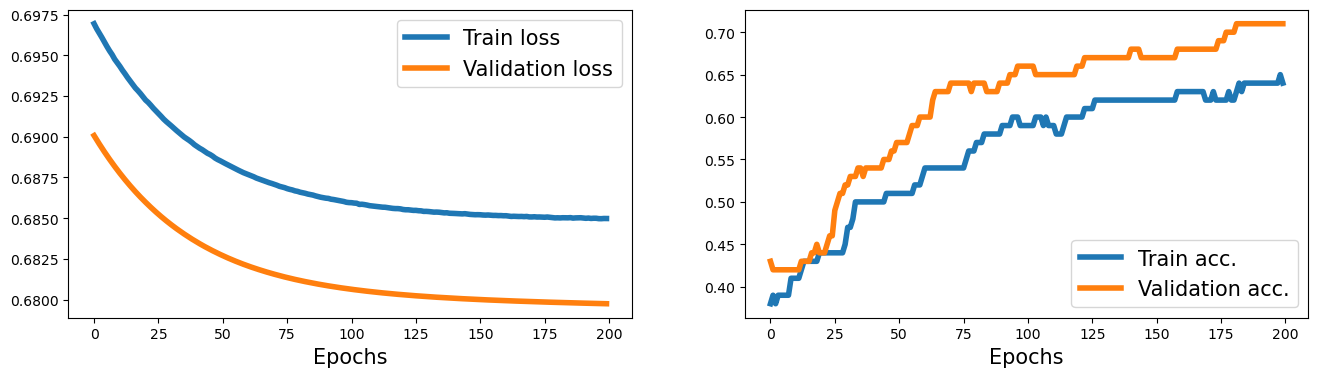

In [16]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [17]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [18]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

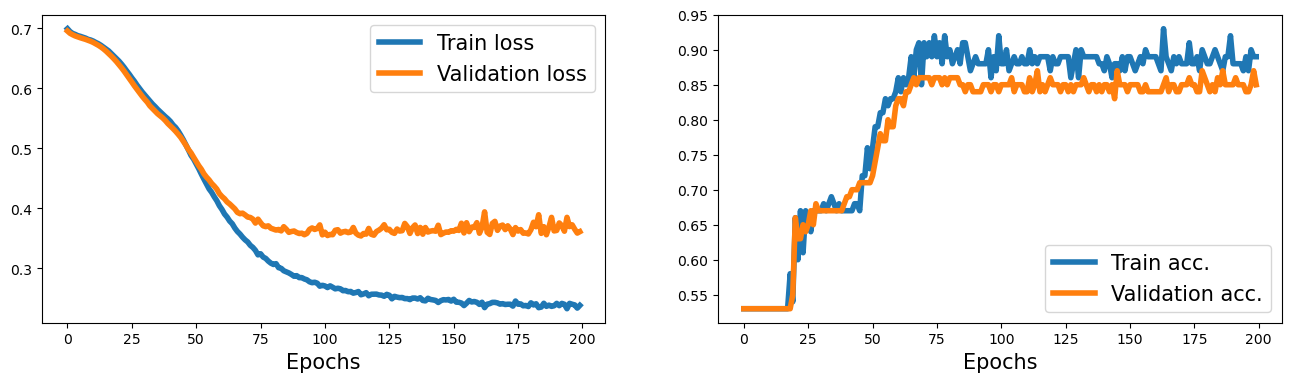

In [19]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [20]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()


model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [21]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

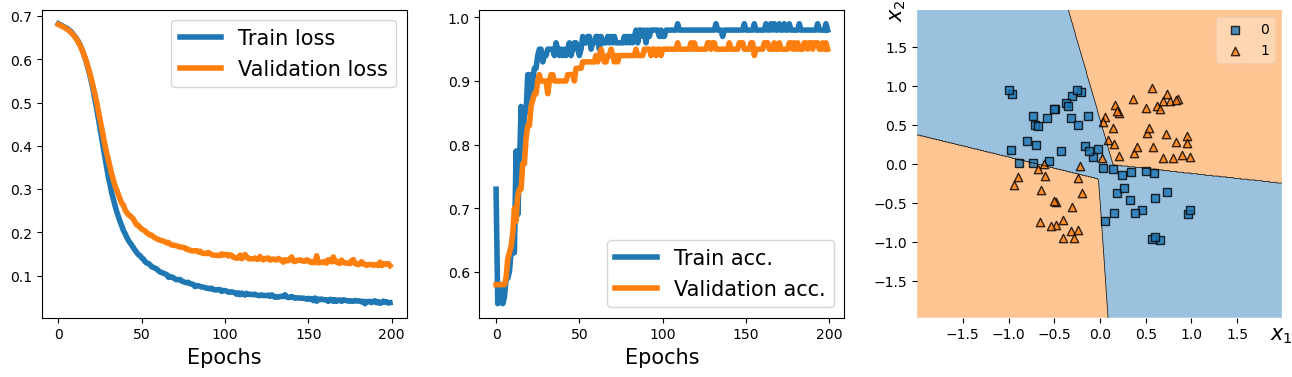

In [22]:
from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.int64), clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

In [23]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)

In [24]:
torch.manual_seed(1)
noisy_layer = NoisyLinear(4, 2)
x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=False))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [25]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()

    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()


torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [26]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred >= 0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= n_train / batch_size
    accuracy_hist_train[epoch] /= n_train / batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred >= 0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

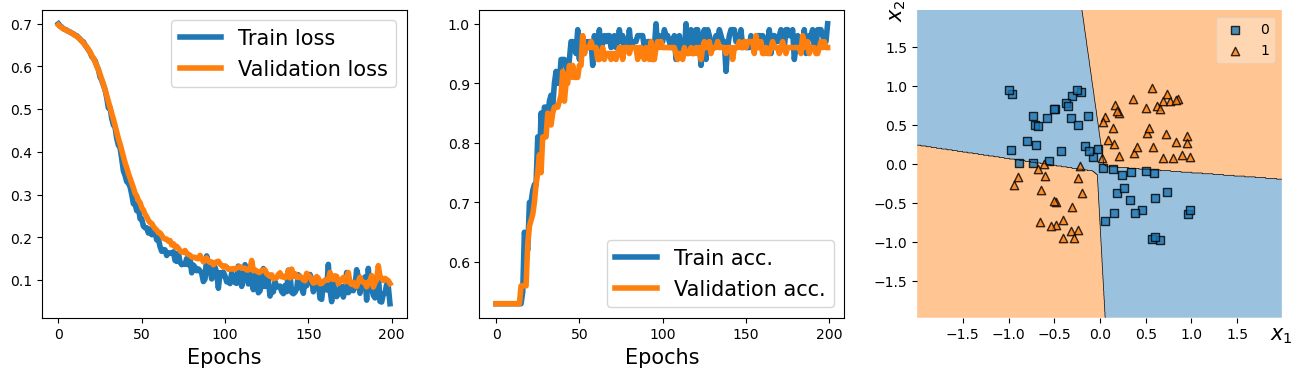

In [27]:
from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.int64), clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

In [29]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import tensorflow as tf

dataset_path = tf.keras.utils.get_file(origin='https://archive.ics.uci.edu/static/public/9/auto+mpg.zip', extract=True)
dataset_path = dataset_path.replace('auto+mpg.zip', 'auto-mpg.data')
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
df = pd.read_csv(dataset_path, names=column_names, na_values="?", comment='\t', sep=" ", skipinitialspace=True)

In [30]:
df = df.dropna()
df = df.reset_index(drop=True)
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1
391,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [31]:
import sklearn
import sklearn.model_selection

df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8, random_state=1)
train_stats = df_train.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,313.0,23.404153,7.666909,9.0,17.5,23.0,29.0,46.6
Cylinders,313.0,5.402556,1.701506,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,189.512780,102.675646,68.0,104.0,140.0,260.0,455.0
Horsepower,313.0,102.929712,37.919046,46.0,75.0,92.0,120.0,230.0
Weight,313.0,2961.198083,848.602146,1613.0,2219.0,2755.0,3574.0,5140.0
Acceleration,313.0,15.704473,2.725399,8.5,14.0,15.5,17.3,24.8
Model Year,313.0,75.929712,3.675305,70.0,73.0,76.0,79.0,82.0
Origin,313.0,1.591054,0.807923,1.0,1.0,1.0,2.0,3.0


In [32]:
numeric_column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col_name in numeric_column_names:
    mean = train_stats.loc[col_name, 'mean']
    std = train_stats.loc[col_name, 'std']
    df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean) / std
    df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name] - mean) / std

df_train_norm.tail()

/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_83705/3941856451.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.8243028   0.3511267  -0.8243028  -0.8243028  -0.8243028   1.52655621
  0.3511267  -0.8243028  -0.8243028  -0.8243028   0.3511267  -0.8243028
  0.3511267   1.52655621  1.52655621  1.52655621  0.3511267   1.52655621
 -0.8243028   0.3511267   1.52655621 -0.8243028  -0.8243028   0.3511267
 -0.8243028  -0.8243028  -0.8243028   0.3511267  -0.8243028   1.52655621
  0.3511267  -0.8243028   0.3511267  -0.8243028  -0.8243028   1.52655621
 -0.8243028   1.52655621  1.52655621 -0.8243028  -0.8243028  -0.8243028
 -0.8243028   0.3511267  -0.8243028   1.52655621 -0.8243028  -0.8243028
  1.52655621 -0.8243028  -0.8243028  -0.8243028   1.52655621  1.52655621
  0.3511267   0.3511267   1.52655621 -0.8243028  -0.8243028   1.52655621
  1.52655621 -0.8243028  -0.8243028   0.3511267   1.52655621 -0.8243028
  

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
203,28.0,-0.824303,-0.901020,-0.736562,-0.950031,0.255202,76,3
255,19.4,0.351127,0.413800,-0.340982,0.293190,0.548737,78,1
72,13.0,1.526556,1.144256,0.713897,1.339617,-0.625403,72,1
235,30.5,-0.824303,-0.891280,-1.053025,-1.072585,0.475353,77,1
37,14.0,1.526556,1.563051,1.636916,1.470420,-1.359240,71,1


In [33]:
boundaries = torch.tensor([73, 76, 79])

v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

numeric_column_names.append('Model Year Bucketed')

In [34]:
from torch.nn.functional import one_hot

total_origin = len(set(df_train_norm['Origin']))

origin_encoded = one_hot(torch.from_numpy(df_train_norm['Origin'].values) % total_origin)
x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()

origin_encoded = one_hot(torch.from_numpy(df_test_norm['Origin'].values) % total_origin)
x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()

In [35]:
y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test = torch.tensor(df_test_norm['MPG'].values).float()

In [36]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [37]:
hidden_units = [8, 4]
input_size = x_train.shape[1]

all_layers = []
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))

model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [38]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [39]:
torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()
    if epoch % log_epochs == 0:
        print(f'에포크 {epoch}  손실 {loss_hist_train / len(train_dl):.4f}')

에포크 0  손실 536.1047
에포크 20  손실 8.4361
에포크 40  손실 7.8695
에포크 60  손실 7.1891
에포크 80  손실 6.7064
에포크 100  손실 6.7603
에포크 120  손실 6.3107
에포크 140  손실 6.6884
에포크 160  손실 6.7549
에포크 180  손실 6.2029


In [40]:
with torch.no_grad():
    pred = model(x_test.float())[:, 0]
    loss = loss_fn(pred, y_test)
    print(f'테스트 MSE: {loss.item():.4f}')
    print(f'테스트 MAE: {nn.L1Loss()(pred, y_test).item():.4f}')

테스트 MSE: 9.5907
테스트 MAE: 2.1177


In [41]:
import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_train_dataset = torchvision.datasets.MNIST(root=image_path,
                                                 train=True,
                                                 transform=transform,
                                                 download=True)
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                                train=False,
                                                transform=transform,
                                                download=False)

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 9912422/9912422 [00:02<00:00, 4238343.78it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 28881/28881 [00:00<00:00, 153644.58it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1483704.93it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 4542/4542 [00:00<00:00, 812978.65it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [42]:
hidden_units = [32, 16]
image_size = mnist_train_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]

all_layers = [nn.Flatten()]
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 10))
model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 20
for epoch in range(num_epochs):
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train += is_correct.sum()
    accuracy_hist_train /= len(train_dl.dataset)
    print(f'에포크 {epoch}  정확도 {accuracy_hist_train:.4f}')

에포크 0  정확도 0.8531
에포크 1  정확도 0.9287
에포크 2  정확도 0.9413
에포크 3  정확도 0.9506
에포크 4  정확도 0.9558
에포크 5  정확도 0.9592
에포크 6  정확도 0.9627
에포크 7  정확도 0.9649
에포크 8  정확도 0.9673
에포크 9  정확도 0.9690
에포크 10  정확도 0.9711
에포크 11  정확도 0.9729
에포크 12  정확도 0.9737
에포크 13  정확도 0.9747
에포크 14  정확도 0.9766
에포크 15  정확도 0.9778
에포크 16  정확도 0.9780
에포크 17  정확도 0.9798
에포크 18  정확도 0.9807
에포크 19  정확도 0.9815


In [44]:
pred = model(mnist_test_dataset.data / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'테스트 정확도: {is_correct.mean():.4f}')

테스트 정확도: 0.9647


In [45]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torchmetrics import __version__ as torchmetrics_version
from pkg_resources import parse_version
from torchmetrics import Accuracy


class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, image_shape=(1, 28, 28), hidden_units=(32, 16)):
        super().__init__()
        self.train_acc = Accuracy(task="multiclass", num_classes=10)
        self.valid_acc = Accuracy(task="multiclass", num_classes=10)
        self.test_acc = Accuracy(task="multiclass", num_classes=10)

        input_size = image_shape[0] * image_shape[1] * image_shape[2]
        all_layers = [nn.Flatten()]
        for hidden_unit in hidden_units:
            layer = nn.Linear(input_size, hidden_unit)
            all_layers.append(layer)
            all_layers.append(nn.ReLU())
            input_size = hidden_unit

        all_layers.append(nn.Linear(hidden_units[-1], 10))
        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_acc.update(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.log("train_acc", self.train_acc.compute())
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.valid_acc.update(preds, y)
        self.log("valid_loss", loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.log("valid_acc", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_acc.update(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_acc.compute(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [46]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms


class MnistDataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        self.transform = transforms.Compose([transforms.ToTensor()])

    def prepare_data(self):
        MNIST(root=self.data_path, download=True)

    def setup(self, stage=None):
        mnist_all = MNIST(
            root=self.data_path,
            train=True,
            transform=self.transform,
            download=False
        )

        self.train, self.val = random_split(
            mnist_all, [55000, 5000], generator=torch.Generator().manual_seed(1)
        )

        self.test = MNIST(
            root=self.data_path,
            train=False,
            transform=self.transform,
            download=False
        )

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=64, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=64, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=64, num_workers=2)


torch.manual_seed(1)
mnist_dm = MnistDataModule()

In [48]:
from pytorch_lightning.callbacks import ModelCheckpoint

mnistclassifier = MultiLayerPerceptron()
callbacks = [ModelCheckpoint(save_top_k=1, mode='max', monitor="valid_acc")]

if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=10, callbacks=callbacks, gpus=1)
else:
    trainer = pl.Trainer(max_epochs=10, callbacks=callbacks)

trainer.fit(model=mnistclassifier, datamodule=mnist_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | train_acc | MulticlassAccuracy | 0      | train
1 | valid_acc | MulticlassAccuracy | 0      | train
2 | test_acc  | MulticlassAccuracy | 0      | train
3 | model     | Sequential         | 25.8 K | train
---------------------------------------------------------
25.8 K    Trainable params
0         Non-trainable params
25.8 K    Total params
0.103     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [49]:
trainer.test(model=mnistclassifier, datamodule=mnist_dm, ckpt_path='best')

Restoring states from the checkpoint path at /Users/llouis/Desktop/LLouis/AI_and_Data_Deep_Dive/PyTorch ML Handbook/13장. 파이토치 구조 자세히 알아보기/lightning_logs/version_0/checkpoints/epoch=8-step=7740.ckpt
Loaded model weights from the checkpoint at /Users/llouis/Desktop/LLouis/AI_and_Data_Deep_Dive/PyTorch ML Handbook/13장. 파이토치 구조 자세히 알아보기/lightning_logs/version_0/checkpoints/epoch=8-step=7740.ckpt
/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9555082321166992     │
│         test_loss         │    0.13700789213180542    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.13700789213180542, 'test_acc': 0.9555082321166992}]